In [168]:
import numpy as np
from sklearn.decomposition import PCA
import os
import pickle

class RecursivePCA:
    def __init__(self, input_size, output_size, num_layers):
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.pcas = []

        # Calculate the size for each layer
        difference = input_size - output_size
        avg_step = difference // num_layers
        extra = difference % num_layers

        for i in range(num_layers):
            n_components = input_size - avg_step
            if extra > 0:
                n_components -= 1
                extra -= 1
            n_components = max(n_components, output_size)  # Ensure we don't go below the output size
            self.pcas.append(PCA(n_components=n_components))
            input_size = n_components

    def fit(self, X):
        temp_data = X
        for pca in self.pcas:
            temp_data = pca.fit_transform(temp_data)
        return self
    
    def transform(self, X):
        temp_data = X
        for pca in self.pcas:
            temp_data = pca.transform(temp_data)
        return temp_data
    
    def inverse_transform(self, X):
        temp_data = X
        for pca in reversed(self.pcas):
            temp_data = pca.inverse_transform(temp_data)
            if len(temp_data.shape) == 3:
                temp_data = temp_data.squeeze(0)
        return temp_data
    
    def save(self, dir_name):
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            
        for i, pca in enumerate(self.pcas):
            with open(os.path.join(dir_name, f'pca_layer_{i}.pkl'), 'wb') as f:
                pickle.dump(pca, f)
                
    def load(self, dir_name):
        self.pcas = []
        for i in range(self.num_layers):
            with open(os.path.join(dir_name, f'pca_layer_{i}.pkl'), 'rb') as f:
                pca = pickle.load(f)
                self.pcas.append(pca)
    
    def compute_loss_at_each_layer(self, data):
        temp_data = data
        losses = []

        for pca in self.pcas:
            transformed_data = pca.transform(temp_data)
            cumulative_explained_variance = np.sum(pca.explained_variance_ratio_)
            loss = 1 - cumulative_explained_variance
            losses.append(loss)
            temp_data = transformed_data

        return losses
    def components_at_each_layer(self):
        return [pca.n_components_ for pca in self.pcas]


In [169]:
import numpy as np
from tensorflow.keras.datasets import mnist

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape and normalize the data to be in the range [0,1]
train_images = train_images.reshape(train_images.shape[0], 28*28).astype('float32') / 255
test_images = test_images.reshape(test_images.shape[0], 28*28).astype('float32') / 255

# Create an instance of RecursivePCA
input_size = 28 * 28
output_size = 10
num_layers = 200
r_pca = RecursivePCA(input_size, output_size, num_layers)


# Fit on training data
r_pca.fit(train_images)

# Transform the data
compressed_train_data = r_pca.transform(train_images)

# Print the shape to see the compressed size
print(compressed_train_data.shape)  # This should show (60000, 2)

# Inverse Transform the data
reconstructed_train_data = r_pca.inverse_transform(compressed_train_data)

# Let's see the reconstruction error (MSE)
mse = np.mean((train_images - reconstructed_train_data)**2)
print(f"Reconstruction MSE: {mse}")

# Save the PCA models
r_pca.save("pca_dir")



(60000, 10)
Reconstruction MSE: 0.03442259877920151


In [170]:
# To demonstrate loading, we'll load the PCA models back
loaded_r_pca = RecursivePCA(input_size, output_size, num_layers)
loaded_r_pca.load("pca_dir")

# Transform using loaded PCA
compressed_test_data = loaded_r_pca.transform(test_images)
print(compressed_test_data.shape)  # This should show (10000, 2)


(10000, 10)


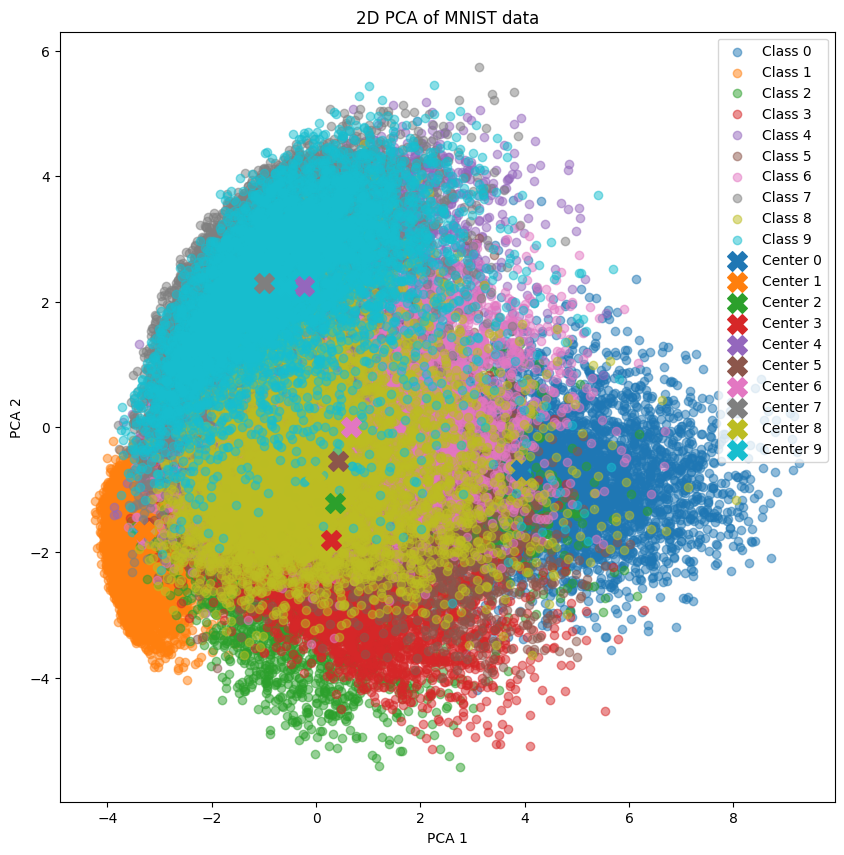

In [171]:
import matplotlib.pyplot as plt

def compute_centers(data, labels):
    centers = {}
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        indices = np.where(labels == label)
        centers[label] = np.mean(data[indices], axis=0)
    
    return centers

# Compute centers for each class in MNIST dataset
centers = compute_centers(compressed_train_data, train_labels)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points
for i in range(10):  # there are 10 classes in MNIST
    indices = np.where(train_labels == i)
    ax.scatter(compressed_train_data[indices, 0], compressed_train_data[indices, 1], label=f'Class {i}', alpha=0.5)

# Plot the centers
for i, center in centers.items():
    ax.scatter(center[0], center[1], marker='X', s=200, label=f'Center {i}')

ax.set_title('2D PCA of MNIST data')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.legend()
plt.show()


In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Compress test data for evaluation
compressed_test_data = r_pca.transform(test_images)

# Create a logistic regression model
logistic_model = LogisticRegression(max_iter=10000)  # max_iter may need to be increased based on convergence

# Train the model on the compressed training data
logistic_model.fit(compressed_train_data, train_labels)

# Predict on the compressed test data
predicted_labels = logistic_model.predict(compressed_test_data)

# Calculate the accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")


Accuracy on test data: 80.90%


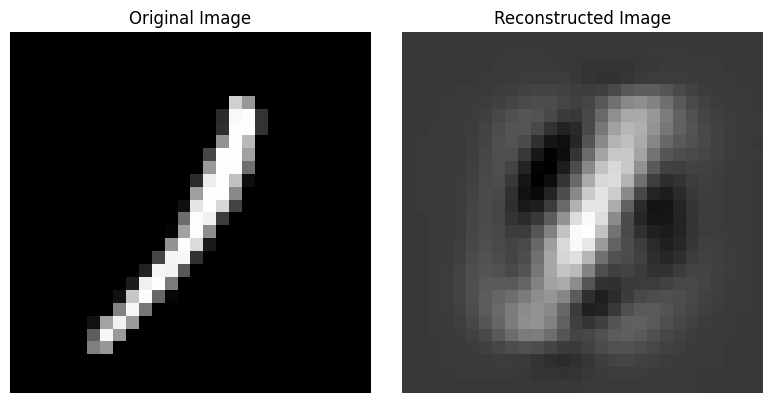

In [181]:
import random

# Randomly select an index from the test set
random_idx = random.randint(0, len(test_images) - 1)
original_image = test_images[random_idx]

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image.reshape(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Transform and then inverse_transform
compressed_image = r_pca.transform(original_image.reshape(1, -1))
reconstructed_image = r_pca.inverse_transform(compressed_image)

# Display the reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.reshape(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [174]:
losses = r_pca.compute_loss_at_each_layer(train_images)
#losses

In [175]:
components = r_pca.components_at_each_layer()
#components

In [182]:
def generate_transition_video(r_pca, data, labels, class_start, class_end, steps=240):
    # Get random samples for the start and end classes
    start_samples = compressed_train_data[labels == class_start]
    end_samples = compressed_train_data[labels == class_end]
    
    start_point = start_samples[np.random.choice(len(start_samples))]
    end_point = end_samples[np.random.choice(len(end_samples))]

    # Generate interpolation points
    interpolation_points = [start_point + (end_point - start_point) * t/steps for t in range(steps)]
    
    # Transform these PCA points back to the image space
    images = [r_pca.inverse_transform(point.reshape(1, -1)).reshape(28, 28) for point in interpolation_points]
    
    # Save as video
    with imageio.get_writer('transition.mp4', fps=24) as writer:
        for img in images:
            writer.append_data((img * 255).astype(np.uint8))
            
    print("Video saved as transition.mp4")

# Make sure to load the MNIST data and initialize the RecursivePCA before calling
generate_transition_video(r_pca, train_images, train_labels, 2, 3)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (28, 28) to (32, 32) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved as transition.mp4


In [177]:
def generate_transition_video(r_pca, data, labels, class_start, class_end, steps=240):
    # Compute average PCA representation of each class
    centers = compute_centers(compressed_train_data, labels)
    
    # Generate interpolation points
    start_point = centers[class_start]
    end_point = centers[class_end]
    interpolation_points = [start_point + (end_point - start_point) * t/steps for t in range(steps)]
    
    # Transform these PCA points back to the image space
    images = [r_pca.inverse_transform(point.reshape(1, -1)).reshape(28, 28) for point in interpolation_points]
    
    # Save as video
    with imageio.get_writer('transition.mp4', fps=24) as writer:
        for img in images:
            writer.append_data((img * 255).astype(np.uint8))
            
    print("Video saved as transition.mp4")

# Make sure to load the MNIST data and initialize the RecursivePCA before calling
generate_transition_video(r_pca, train_images, train_labels, 2, 3)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (28, 28) to (32, 32) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved as transition.mp4


In [135]:
input_n=700
output=2
rounds=30
delta = input_n - output

for i in range (1, rounds):
    reduce = (delta*i)/(10+i)
    #print(reduce)
    delta = delta - reduce
    print (round(delta))
    


635
529
407
291
194
121
71
40
21
10
5
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
